In [245]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import pickle
import joblib

Importing the trained and test sets and separating their final weight.

In [246]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
final_weight_train = train["Final Weight"]
x_train = train.drop(columns = ['Income', 'Final Weight'])
y_train = train['Income']

final_weight_test = test["Final Weight"]
x_test = test.drop(columns = ['Income', 'Final Weight'])
y_test = test['Income']

Importing the trained, tuned models and using them to make predictions on the test set. (Decison Tree, CategoricalNB)

In [247]:
# Decision Tree
tuned_model_dt = joblib.load('dt.pkl')
y_pred_test_dt = tuned_model_dt.predict(x_test)

#CategoricalNB
tuned_model_cnb = joblib.load('bayes.pkl')
y_pred_test_cnb = tuned_model_cnb.predict(x_test)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


Standardize the data for neural networks and KNN as they are sensitive to feature scaling

In [248]:
stds = StandardScaler()
stds.fit(x_train)
x_train = stds.transform(x_train)
x_test = stds.transform(x_test)

Importing tuned and trained neural MLP and KNN classifiers and using them to predict the target variable

In [249]:
#MLP
with open('mlp.obj', 'rb') as f:
    tuned_model_mlp = pickle.load(f)
y_pred_test_mlp = tuned_model_mlp.predict(x_test)
#KNN
tuned_model_knn = joblib.load('knn.pkl')
y_pred_test_knn = tuned_model_knn.predict(x_test)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator LabelBinarizer from version 1.0.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator MLPClassifier from version 1.0.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


# Stacking

getting the hard mode voting predicted result based on the predicted output of the other 4 base models

In [ ]:
y_pred_test_stacking =[]#predicted result will be put into the list
for i in range(len(y_pred_test_dt)):
    final = []#totally 9035 final lists for adding predicted result (0 or 1) from dt, knn, cnb and mlp
    final.append(y_pred_test_dt[i])#append each predicted result of decision tree
    final.append(y_pred_test_knn[i])#append each predicted result of k nearest neighbor
    final.append(y_pred_test_cnb[i])#append each predicted result of categoricalNB
    final.append(y_pred_test_mlp[i])#append each predicted result of neural networks
#getting the mode of predicted result of 4 algorithms, and add the mode value to be the predicted result for hard voting
    if final.count(1) < final.count(0):
        y_pred_test_stacking.append(0)
    else:
        y_pred_test_stacking.append(1)

Predicting output of Income on testing set.

In [ ]:
y_pred_test_stacking = np.array(y_pred_test_stacking)

confusion_matrix = confusion_matrix(y_test,y_pred_test_stacking)

https://vitalflux.com/python-draw-confusion-matrix-matplotlib/
- reference for making the confusion matrix

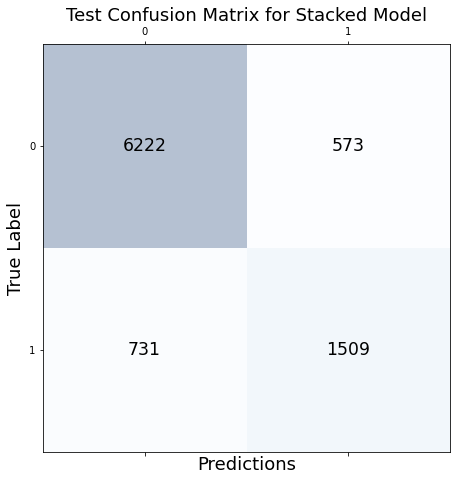

In [ ]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(confusion_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        ax.text(x=j, y=i,s=confusion_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('True Label', fontsize=18)
plt.title('Test Confusion Matrix for Stacked Model', fontsize=18)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred_test_stacking))

              precision    recall  f1-score   support

           0       0.89      0.92      0.91      6795
           1       0.72      0.67      0.70      2240

    accuracy                           0.86      9035
   macro avg       0.81      0.79      0.80      9035
weighted avg       0.85      0.86      0.85      9035



Creating a function that returns a classification report on the minority class with taking the weight of each row into account in order to produce a more accurate classification report.

In [ ]:
#precision = true_positive / (true_positive + false_positive)
#Recall = true_positive / (true_positive + false_negative)
#f1= (2 * precision * recall) / (precision + recall)

def calculate_weighted_classification(final_weight, y_pred_income, y_actual):
    df = pd.DataFrame(final_weight)
    df["Predicted_Income"] = y_pred_income
    df["Actual_Income"] = y_actual
    true_positive = 0
    false_negatives = 0
    false_positive = 0
    for i in range(len(df)):
        actual_income = df.iloc[i]["Actual_Income"]
        predicted_income = df.iloc[i]["Predicted_Income"]
        final_weight = df.iloc[i]["Final Weight"]
        if actual_income == 1 and predicted_income == 1:
            true_positive += final_weight
        elif actual_income == 1 and predicted_income == 0:
            false_negatives += final_weight
        elif actual_income == 0 and predicted_income == 1:
            false_positive += final_weight
    precision = true_positive / (true_positive + false_positive)
    recall = true_positive / (true_positive + false_negatives)
    f1= (2 * precision * recall) / (precision + recall)
    return precision, recall, f1

<h4>Calculating the precision, recall and f1 scores for the minority class accounting for the final weight of each row.</h4>

Stacked Model:

In [ ]:
precision_stacked, recall_stacked, f1_stacked = calculate_weighted_classification(final_weight_test, y_pred_test_stacking, y_test)
print('Classification report for minority class using the Stacked Model:')
print(f"Weighted Precision: {precision_stacked}")
print(f"Weighted Recall: {recall_stacked}")
print(f"Weighted F1 Score: {f1_stacked}")

Classification report for minority class using the Stacked Model:
Weighted Precision: 0.739504165579235
Weighted Recall: 0.6764855593441129
Weighted F1 Score: 0.7065925412929831


Decision Trees

In [ ]:
precision_dt, recall_dt, f1_dt = calculate_weighted_classification(final_weight_test, y_pred_test_dt, y_test)
print('Classification report for minority class using the Decision Tree Model')
print(f"Weighted Precision: {precision_dt}")
print(f"Weighted Recall: {recall_dt}")
print(f"Weighted F1 Score: {f1_dt}")

Classification report for minority class using the Decision Tree Model
Weighted Precision: 0.762934310944565
Weighted Recall: 0.6255359907647139
Weighted F1 Score: 0.6874369145635915


KNN:

In [ ]:
precision_knn, recall_knn, f1_knn = calculate_weighted_classification(final_weight_test, y_pred_test_knn, y_test)
print('Classification report for minority class using the KNN Model')
print(f"Weighted Precision: {precision_knn}")
print(f"Weighted Recall: {recall_knn}")
print(f"Weighted F1 Score: {f1_knn}")

Classification report for minority class using the KNN Model
Weighted Precision: 0.7385557662845931
Weighted Recall: 0.5648324722708864
Weighted F1 Score: 0.6401166851755185


Categorical NB:

In [ ]:
precision_cnb, recall_cnb, f1_cnb = calculate_weighted_classification(final_weight_test, y_pred_test_cnb, y_test)
print('Classification report for minority class using the Categorical NB Model')
print(f"Weighted Precision: {precision_cnb}")
print(f"Weighted Recall: {recall_cnb}")
print(f"Weighted F1 Score: {f1_cnb}")

Classification report for minority class using the Categorical NB Model
Weighted Precision: 0.6966371586663492
Weighted Recall: 0.6714933624648347
Weighted F1 Score: 0.6838342115254388


Neural MLP:

In [ ]:
precision_mlp, recall_mlp, f1_mlp = calculate_weighted_classification(final_weight_test, y_pred_test_mlp, y_test)
print('Classification report for minority class using the Neural MLP Model')
print(f"Weighted Precision: {precision_mlp}")
print(f"Weighted Recall: {recall_mlp}")
print(f"Weighted F1 Score: {f1_mlp}")

Classification report for minority class using the Neural MLP Model
Weighted Precision: 0.7564726083043368
Weighted Recall: 0.6371039067155141
Weighted F1 Score: 0.6916759128465977


A visual representation of the performance of each algorithm at classifying the minority class.

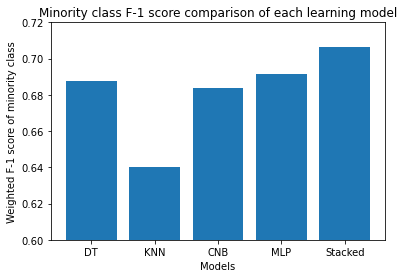

In [ ]:
leaners = ['DT','KNN','CNB','MLP', 'Stacked']
weighted_f1_score = [f1_dt,f1_knn,f1_cnb,f1_mlp,f1_stacked]

plt.bar(leaners, weighted_f1_score)
plt.title('Minority class F-1 score comparison of each learning model')
plt.xlabel('Models')
plt.ylabel('Weighted F-1 score of minority class')
plt.ylim(0.6,0.72)
plt.show()